In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=edc1ba29a917fb05c5d673397413c00ffa31002212e02b6adfd2edc7aa5fa7fb
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "/content/drive/MyDrive/CC Project/Data"

/content/drive/MyDrive/CC Project/Data


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, regexp_extract
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [6]:
spark = SparkSession.builder.appName("CC Project").getOrCreate()
sc = spark.sparkContext

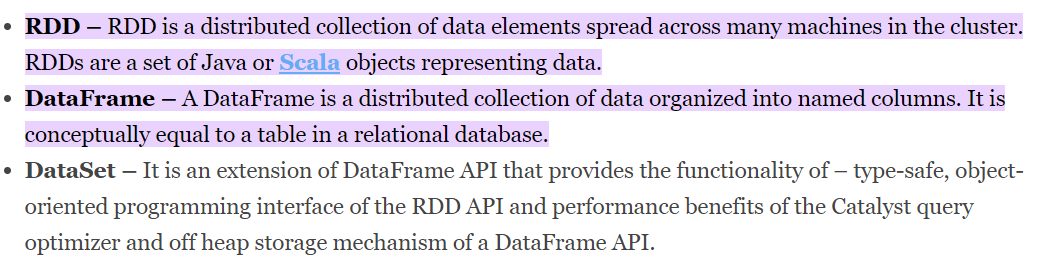

In [7]:
# using spark dataframe instead of traditional RDDs, better performance
df_train = spark.read.csv('/content/drive/MyDrive/CC Project/Data/train.csv', header=True, inferSchema=True)
df_test = spark.read.csv('/content/drive/MyDrive/CC Project/Data/test.csv', header=True, inferSchema=True)

# Data Exploration

Link to pyspark.sql.DataFrame documentation:
https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html

In [ ]:
df_train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [ ]:
df_train.show(3)
df_train.limit(3).toPandas()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 3 rows



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [ ]:
# select based on columns
df_train.select('Survived', 'Pclass', 'Age', 'Fare').show(3)

+--------+------+----+-------+
|Survived|Pclass| Age|   Fare|
+--------+------+----+-------+
|       0|     3|22.0|   7.25|
|       1|     1|38.0|71.2833|
|       1|     3|26.0|  7.925|
+--------+------+----+-------+
only showing top 3 rows



In [ ]:
# summary: equivalent to describe in Pandas
df_train.select('Survived', 'Pclass', 'Age', 'Fare').summary().show()

+-------+-------------------+------------------+------------------+-----------------+
|summary|           Survived|            Pclass|               Age|             Fare|
+-------+-------------------+------------------+------------------+-----------------+
|  count|                891|               891|               714|              891|
|   mean| 0.3838383838383838| 2.308641975308642| 29.69911764705882| 32.2042079685746|
| stddev|0.48659245426485753|0.8360712409770491|14.526497332334035|49.69342859718089|
|    min|                  0|                 1|              0.42|              0.0|
|    25%|                  0|                 2|              20.0|           7.8958|
|    50%|                  0|                 3|              28.0|          14.4542|
|    75%|                  1|                 3|              38.0|             31.0|
|    max|                  1|                 3|              80.0|         512.3292|
+-------+-------------------+------------------+------

In [ ]:
df_train.summary().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [ ]:
df_train.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [ ]:
df_train.groupBy('Survived').mean('Fare', 'Age').show()

+--------+------------------+------------------+
|Survived|         avg(Fare)|          avg(Age)|
+--------+------------------+------------------+
|       1| 48.39540760233917|28.343689655172415|
|       0|22.117886885245877| 30.62617924528302|
+--------+------------------+------------------+



In [ ]:
df_train.groupBy('Survived').pivot('Sex').count().show()

+--------+------+----+
|Survived|female|male|
+--------+------+----+
|       1|   233| 109|
|       0|    81| 468|
+--------+------+----+



# Preparing Train data

In [8]:
#checking null values
for col in df_train.columns:
    print(col, df_train.filter(df_train[col].isNull()).count())

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [9]:
# filling Embarked with most repeated value which was 's'
df_train = df_train.fillna({'Embarked': 'S'})

filling missing Age values based on titles (suggested in [this notebook](https://www.kaggle.com/code/konstantinmasich/titanic-0-82-0-83/notebook))

In [10]:
df_train = df_train.withColumn('Title', regexp_extract(df_train['Name'], '([A-Za-z]+)\.', 1))

title_dic = {'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master', \
             'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',\
             'Don': 'Mr', 'Mme': 'Miss', 'Jonkheer': 'Mr', 'Lady': 'Mrs',\
             'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs', \
             'Dr':'Mr', 'Rev':'Mr'}

df_train = df_train.replace(to_replace=title_dic, subset='Title')
df_train.groupBy('Title').mean('Age').show()

+------+------------------+
| Title|          avg(Age)|
+------+------------------+
|  Miss|             21.86|
|Master| 4.574166666666667|
|    Mr| 33.02272727272727|
|   Mrs|35.981818181818184|
+------+------------------+



In [11]:
df_train = df_train.withColumn('Age', when((df_train['Age'].isNull()) & (df_train['Title']=="Mr"), 33.02).otherwise(df_train['Age']))
df_train = df_train.withColumn('Age', when((df_train['Age'].isNull()) & (df_train['Title']=="Mrs"), 35.98).otherwise(df_train['Age']))
df_train = df_train.withColumn('Age', when((df_train['Age'].isNull()) & (df_train['Title']=="Master"), 4.57).otherwise(df_train['Age']))
df_train = df_train.withColumn('Age', when((df_train['Age'].isNull()) & (df_train['Title']=="Miss"), 21.86).otherwise(df_train['Age']))

In [12]:
# Combining Parch and SibSp
df_train = df_train.withColumn('FamilySize', df_train['Parch'] + df_train['SibSp'])

In [13]:
df_train = df_train.drop('PassengerId', 'Name', 'SibSp', 'Parch','Ticket', 'Cabin', 'Title')

In [14]:
#checking null values
for col in df_train.columns:
    print(col, df_train.filter(df_train[col].isNull()).count())

Survived 0
Pclass 0
Sex 0
Age 0
Fare 0
Embarked 0
FamilySize 0


In [15]:
# Converting cateforical values to numerical values
stringIndex = StringIndexer(inputCols=['Sex', 'Embarked'], outputCols=['SexNum', 'EmbNum'])

stringIndex_model = stringIndex.fit(df_train)

df_train = stringIndex_model.transform(df_train).drop('Sex', 'Embarked')
df_train.show(3)

+--------+------+----+-------+----------+------+------+
|Survived|Pclass| Age|   Fare|FamilySize|SexNum|EmbNum|
+--------+------+----+-------+----------+------+------+
|       0|     3|22.0|   7.25|         1|   0.0|   0.0|
|       1|     1|38.0|71.2833|         1|   1.0|   1.0|
|       1|     3|26.0|  7.925|         0|   1.0|   0.0|
+--------+------+----+-------+----------+------+------+
only showing top 3 rows



# Preparing Test data

In [16]:
#checking null values
for col in df_test.columns:
    print(col, df_test.filter(df_test[col].isNull()).count())

PassengerId 0
Pclass 0
Name 0
Sex 0
Age 86
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0


In [17]:
# filling Fare with with the median of this feature in train data (14.45)
df_test = df_test.fillna({'Fare': 14.45})

In [18]:
df_test = df_test.withColumn('Title', regexp_extract(df_test['Name'], '([A-Za-z]+)\.', 1))

title_dic = {'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master', \
             'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',\
             'Don': 'Mr', 'Mme': 'Miss', 'Jonkheer': 'Mr', 'Lady': 'Mrs',\
             'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs', \
             'Dr':'Mr', 'Rev':'Mr'}

df_test = df_test.replace(to_replace=title_dic, subset='Title')

In [19]:
# filling age feature based on what we calculated from train data
df_test = df_test.withColumn('Age', when((df_test['Age'].isNull()) & (df_test['Title']=="Mr"), 33.02).otherwise(df_test['Age']))
df_test = df_test.withColumn('Age', when((df_test['Age'].isNull()) & (df_test['Title']=="Mrs"), 35.98).otherwise(df_test['Age']))
df_test = df_test.withColumn('Age', when((df_test['Age'].isNull()) & (df_test['Title']=="Master"), 4.57).otherwise(df_test['Age']))
df_test = df_test.withColumn('Age', when((df_test['Age'].isNull()) & (df_test['Title']=="Miss"), 21.86).otherwise(df_test['Age']))

In [20]:
# Combining Parch and SibSp
df_test = df_test.withColumn('FamilySize', df_test['Parch'] + df_test['SibSp'])

In [21]:
df_test = df_test.drop('PassengerId', 'Name', 'SibSp', 'Parch','Ticket', 'Cabin', 'Title')

In [22]:
#checking null values
for col in df_test.columns:
    print(col, df_test.filter(df_test[col].isNull()).count())

Pclass 0
Sex 0
Age 0
Fare 0
Embarked 0
FamilySize 0


In [23]:
# Converting cateforical values to numerical values
stringIndex = StringIndexer(inputCols=['Sex', 'Embarked'], outputCols=['SexNum', 'EmbNum'])

stringIndex_model = stringIndex.fit(df_test)

df_test = stringIndex_model.transform(df_test).drop('Sex', 'Embarked')
df_test.show(3)

+------+----+------+----------+------+------+
|Pclass| Age|  Fare|FamilySize|SexNum|EmbNum|
+------+----+------+----------+------+------+
|     3|34.5|7.8292|         0|   0.0|   2.0|
|     3|47.0|   7.0|         1|   1.0|   0.0|
|     2|62.0|9.6875|         0|   0.0|   2.0|
+------+----+------+----------+------+------+
only showing top 3 rows



# Training

In [24]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [25]:
# Convert dataframe to Vectors so that they can be fed to spark ML models

vec_asmbl = VectorAssembler(inputCols=df_train.columns[1:], outputCol='features')

df_train = vec_asmbl.transform(df_train).select('features', 'Survived')

df_train.show(4, truncate=False)

+------------------------------+--------+
|features                      |Survived|
+------------------------------+--------+
|[3.0,22.0,7.25,1.0,0.0,0.0]   |0       |
|[1.0,38.0,71.2833,1.0,1.0,1.0]|1       |
|[3.0,26.0,7.925,0.0,1.0,0.0]  |1       |
|[1.0,35.0,53.1,1.0,1.0,0.0]   |1       |
+------------------------------+--------+
only showing top 4 rows



In [26]:
df_train, df_val = df_train.randomSplit([0.7, 0.3])
df_train.show(4, truncate=False)

+---------------------+--------+
|features             |Survived|
+---------------------+--------+
|(6,[0,1],[1.0,33.02])|0       |
|(6,[0,1],[1.0,38.0]) |0       |
|(6,[0,1],[1.0,39.0]) |0       |
|(6,[0,1],[1.0,40.0]) |0       |
+---------------------+--------+
only showing top 4 rows



spark VectorAssembeler Compresses sparse matrixes

(6,[0,1],[1.0,33.02]) means:

we have 6 element at total, we only have non-zero elements in 0 and 1 indices and the values of these non-zero elements are given in the last list in this representation.

In [ ]:
df_train.toPandas().head(4)

,features,Survived
0,"(1.0, 33.02, 0.0, 0.0, 0.0, 0.0)",0
1,"(1.0, 33.02, 0.0, 0.0, 0.0, 0.0)",0
2,"(1.0, 38.0, 0.0, 0.0, 0.0, 0.0)",0
3,"(1.0, 39.0, 0.0, 0.0, 0.0, 0.0)",0


In [27]:
# Craeting the Evaluator instanse
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='accuracy')

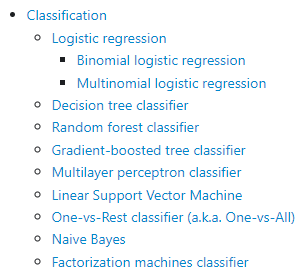

In [ ]:
ridge = LogisticRegression(labelCol='Survived', 
                        maxIter=200, 
                        elasticNetParam=0, # Ridge regression
                        regParam=0.04)

model = ridge.fit(df_train)
pred = model.transform(df_val)
evaluator.evaluate(pred)

0.773851590106007

In [ ]:
lasso = LogisticRegression(labelCol='Survived', 
                           maxIter=200,
                           elasticNetParam=1, # Lasso
                           regParam=0.0005)

model = lasso.fit(df_train)
pred = model.transform(df_val)
evaluator.evaluate(pred)

0.7703180212014135

In [28]:
rf = RandomForestClassifier(labelCol='Survived', numTrees=100, maxDepth=3)

model = rf.fit(df_train)
pred = model.transform(df_val)
evaluator.evaluate(pred)

0.8127340823970037

In [ ]:
gb = GBTClassifier(labelCol='Survived', maxIter=75, maxDepth=3)

model = gb.fit(df_train)
pred = model.transform(df_val)
evaluator.evaluate(pred)

0.8021201413427562

# Finding best hyper parameters and make prediction on test data

In [29]:
paramGrid = ParamGridBuilder().\
            addGrid(rf.maxDepth, [3, 4, 5]).\
            addGrid(rf.minInfoGain, [0., 0.01, 0.1]).\
            addGrid(rf.numTrees, [100, 500, 700, 1000]).\
            build()

selected_model = CrossValidator(estimator=rf, 
                                estimatorParamMaps=paramGrid, 
                                evaluator=evaluator, 
                                numFolds=5)
df = df_train.union(df_val)
model_final = selected_model.fit(df)
pred_train = model_final.transform(df)
evaluator.evaluate(pred_train)

0.8395061728395061

In [31]:
temp = model_final.bestModel._java_obj
print(f"optimal maxDepth: {temp.getMaxDepth()}")
print(f"optimal minInfoGain: {temp.getMinInfoGain()}")
print(f"optimal numTrees: {temp.getNumTrees()}")

optimal maxDepth: 4
optimal minInfoGain: 0.0
optimal numTrees: 700


In [32]:
vec_asmbl = VectorAssembler(inputCols=df_test.columns, outputCol='features')

df_test = vec_asmbl.transform(df_test).select('features')

In [33]:
pred_test = model_final.transform(df_test)

predictions = pred_test.select('prediction')
predictions.show(10)

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
+----------+
only showing top 10 rows

